In [1]:
using Revise

In [2]:
using QuantumStates
using UnitsToValue

### Load $X(01^10)$ Hamiltonian

In [67]:
H0 = load_from_file("CaF_v0_N0to3_Hamiltonian", "C://Users//Christian//Google Drive//github//QuantumStates//Hamiltonians//CaF//")
;

In [68]:
const μX = 1e-6 * 3.07 * (1e-21 / c) / h;

In [69]:
import QuantumStates: polarizability, Zeeman

w = 25e-6; P = 13.25; I_trap = 2P / (π * w^2);
const α = [3.37471e-39, 0, -1.01809e-39] # 1064 nm
const θ = 0 * (π / 2)
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
polarizability(state, state′) = polarizability(state, state′, α, ϵ_trap)
# @time H = add_to_H(H0, :I_trap, (1e-6 / h) * polarizability)

@time H = add_to_H(H0, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# const B_x = [1.0, 0.0, -1.0] ./ √2
# const B_z = [0.0, 1.0, 0.0]
# Zeeman_x(state, state′) = (1/√2)  * (Zeeman(state, state′, -1) - Zeeman(state, state′, +1))
# Zeeman_y(state, state′) = (im/√2) * (Zeeman(state, state′, -1) + Zeeman(state, state′, +1))
# Zeeman_z(state, state′) = Zeeman(state, state′, 0)
# H = add_to_H(H, :B_x, gS * μ_B * Zeeman_x)
# H = add_to_H(H, :B_y, gS * μ_B * Zeeman_y)
# H = add_to_H(H, :B_z, gS * μ_B * Zeeman_z)

# H.parameters.I_trap = (1.0 / 3.5) * I_trap / (2ε_0 * c)
# H.parameters.E = 198 * 0.3
# H.parameters.B_x = 0.0
# H.parameters.B_z = 1e-6

@time full_evaluate!(H)
@time solve!(H)
;

  0.005649 seconds (37 allocations: 326.000 KiB)


  0.013623 seconds (45.91 k allocations: 4.617 MiB)
  0.009627 seconds (592 allocations: 1.405 MiB)


### Plot trap intensity dependence

In [70]:
I_trap_scan_range = (0:0.02:1) .* I_trap / (2ε0 * c)
x = scan_single_parameter(deepcopy(H), :I_trap, I_trap_scan_range);

LoadError: UndefVarError: ε0 not defined

In [71]:
plot_values = zeros(length(I_trap_scan_range), length(H.states))
for (i, I_trap_value) ∈ enumerate(sort(collect(keys(x.state_dict))))
    plot_values[i,:] = energy.(x.state_dict[I_trap_value])
end

LoadError: UndefVarError: I_trap_scan_range not defined

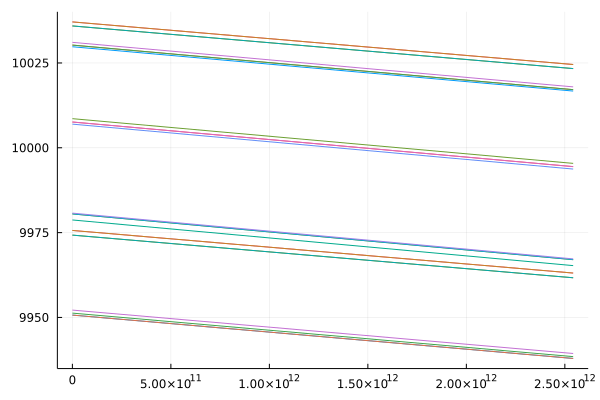

In [7]:
plot(I_trap_scan_range, plot_values[:,1:24], legend=nothing)

### Electric field scan

In [47]:
using LaTeXStrings

In [48]:
function H_func!(H, scan_values)
    H.parameters.E = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [79]:
Es = 0.0:5000.0:200000
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.815903 seconds (195.56 k allocations: 87.557 MiB, 17.36% compilation time)


In [80]:
matrix_values = hcat(values(scan_values)...)';

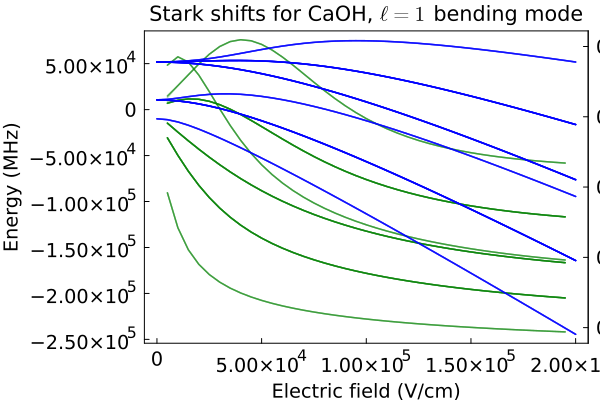

In [85]:
using Plots
using Plots.PlotMeasures
xs = collect(Es)
ys = matrix_values[:,1:36] .- 10000
plot(xs[1:end-1][2:end], differences_derivative(xs, ys)[2:end,:] * 180000, linewidth=1.5, linecolor=:green, alpha=0.3)
plot!(xs, ys, linewidth=1.5, linecolor=:blue, alpha=0.5)
plot!(
    legend=nothing, 
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel="Energy (MHz)",
    labelfontsize=13,
    tickfontsize=13,
    grid=:off,
    box=:on,
    # ylim=(-250,250),
    title=L"Stark shifts for CaOH, $\ell = 1$ bending mode"
    )
plot!(twinx(),color=:red,xticks=:none,label="right",yticks=0.05:0.225:0.95,tickfontsize=13)

In [30]:
function differences_derivative(xs, ys)
    ys_diff = ys[2:end,:] .- ys[1:end-1,:]
    xs_diff = xs[2:end] - xs[1:end-1]
    return ys_diff ./ xs_diff
end; 

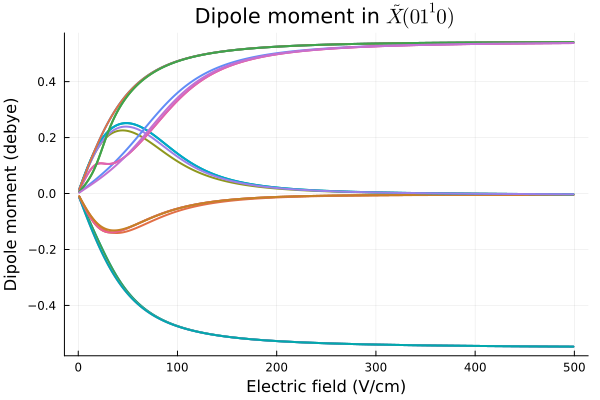

In [89]:
using Plots
plot!(xs[1:end-1][2:end], differences_derivative(xs, ys)[2:end,:] * 1.486, linewidth=2)
plot!(
    legend=nothing, 
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel="Dipole moment (debye)",
    title=L"Dipole moment in $\widetilde{X}(01^10)$"
    )

### Decoupled basis

In [20]:
H.parameters.E = 62.0
H.parameters.B_z = 0.0
evaluate!(H); solve!(H);

In [21]:
QN_bounds = (S = 1/2, I = 1/2, Λ = [-1,1], N = 1:3)
basis_decoupled = enumerate_states(HundsCaseB_Decoupled, QN_bounds)
states_decoupled = convert_basis(x.state_dict[62], basis_decoupled)
;

In [22]:
expectation(states_decoupled[subspace(H.states, (N=1,))[1][14]], :M_S)

0.005600369479115385 + 0.0im

In this basis, the first-order Stark shifts are given by the product $\Lambda M_N$:

In [23]:
idxs = subspace(states_decoupled, (M_N = 0,))[1];

### Magnetic field scan

In [24]:
using Plots.PlotMeasures

In [114]:
H.parameters

ParameterList(Dict(:B_y => 0.0, :cX => 2.053, :I_trap => 7.26354298635441e11, :DX => 0.0117818435994, :BX => 9996.819345976399, :B_z => 0.00101, :γX => 35.4954270272, :B_x => 0.0, :qX => 21.52809640898, :bFX => 2.602…))

In [45]:
H.parameters.E = 0.0
evaluate!(H) 
solve!(H)
states_idxs = subspace(H.states, (N=1,))[1]
;

In [57]:
Es = 0.0:0.1:65
g_factors = scan_single_parameter_gfactor(H, :E, Es);

In [88]:
Es[600] / 0.3

199.66666666666666

In [92]:
g_factors[600,14]

6.96036295266822e-8

In [111]:
g_factors[645,19]

-1.0757503332570195e-7

In [113]:
Es[645] / 0.3

214.66666666666669

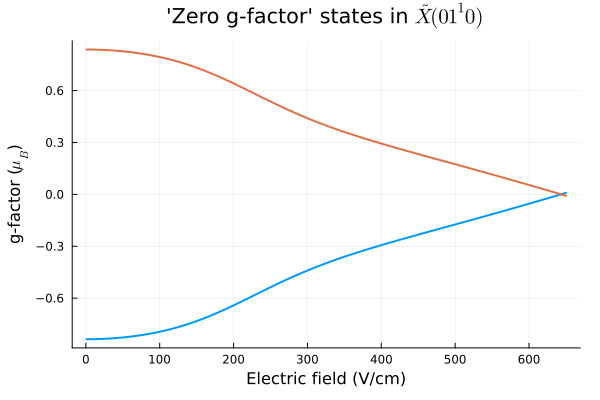

In [95]:
plot(g_factors[2:end, states_idxs[18:19]] ./ maximum(g_factors), linewidth=2)
plot!(
    legend=nothing,
    xlabel="Electric field (V/cm)",
    ylabel=L"g-factor ($\mu_B$)",
    title=L"'Zero g-factor' states in $\widetilde{X}(01^10)$",
    margin=3mm
    )

### Plot $\langle \Sigma \rangle$ versus electric field E

In [20]:
H.parameters.E = 0.0
H.parameters.B = 0.0
evaluate!(H)
solve!(H)

In [21]:
plot_values = zeros(length(E_scan_range), length(H.states))
for (i, E_value) ∈ enumerate(sort(collect(keys(x.state_dict))))
    plot_values[i,:] = Σ.(x.state_dict[E_value])
end

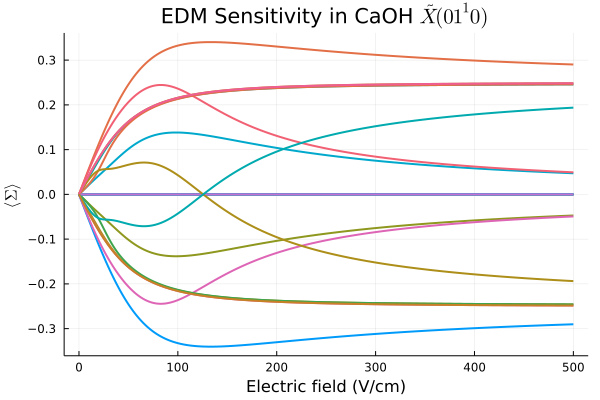

In [22]:
xs = collect(E_scan_range)
ys = plot_values[:,1:24]
plot(xs, ys, linewidth=2)
plot!(
    legend=nothing,
    # size=(1400,700),
    xlabel="Electric field (V/cm)",
    ylabel=L"\langle \Sigma \rangle",
    title=L"EDM Sensitivity in CaOH $\widetilde{X}(01^10)$"
    )